In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 108.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3


In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer,f1_score,confusion_matrix, classification_report,accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split
from imblearn.pipeline import make_pipeline
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import seaborn as sns



In [4]:
# Load and prepare data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amazon-cleaned.csv')

In [5]:
df['discount_percentage'] = ((df['actual_price'] - df['discounted_price']) / df['actual_price']) * 100
df['review_text'] = df['review_title'] + ' ' + df['review_content']
df['review_text'] = df['review_text'].fillna('')
df = df.dropna(subset=['review_text', 'rating', 'discount_percentage', 'category'])

In [6]:
# encode satisfaction: rating < 3 as 0, 3 =< rating < 4 as 1 , rating >= 4 as 2
def encode_satisfaction(rating):
    if rating < 3:
        return 0
    elif rating < 4:
        return 1
    else:
        return 2
df['satisfaction'] = df['rating'].apply(encode_satisfaction)


In [7]:
# Remove duplicate rows (keep first occurrence)
df = df.drop_duplicates()

# Remove duplicate review texts (more aggressive)
df = df.drop_duplicates(subset=['review_text'],keep='first')

In [8]:
# Check class balance
print("Class distribution:\n", df['satisfaction'].value_counts(normalize=True))

Class distribution:
 satisfaction
2    0.730032
1    0.265445
0    0.004523
Name: proportion, dtype: float64


# Cutomers satisfaction prediction


In [9]:
# After cleaning duplicates and removing rating
X = df[['review_text', 'discount_percentage', 'category','rating']]
y = df['satisfaction']

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Simplified preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(
            max_features=500,
            min_df=5, max_df=0.7,
            ngram_range=(1, 2),
            stop_words='english'),
            'review_text'),
        ('num', StandardScaler(), ['rating','discount_percentage']),
        ('cat', OneHotEncoder(max_categories=20, handle_unknown='infrequent_if_exist'),
          ['category'])],
          remainder='drop')

pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(class_weight='balanced', random_state=42)
)

# Hyperparameter grid
param_grid = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_depth': [None, 15],
    'randomforestclassifier__min_samples_split': [5, 10],
    'randomforestclassifier__max_features': ['sqrt', 0.5]
}
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
scoring = make_scorer(f1_score, average='weighted')
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)


Fitting 2 folds for each of 16 candidates, totalling 32 fits


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('text',
                                                                         TfidfVectorizer(max_df=0.7,
                                                                                         max_features=500,
                                                                                         min_df=5,
                                                                                         ngram_range=(1,
                                                                                                      2),
                                                                                         stop_words='english'),
                                                                         'review_text'),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['rating',
                                                                          'discount_percentage']),
                                                                        ('cat',
                                                                         OneHotEncoder(han...
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [None, 15],
                         'randomforestclassifier__max_features': ['sqrt', 0.5],
                         'randomforestclassifier__min_samples_split': [5, 10],
                         'randomforestclassifier__n_estimators': [100, 200]},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted),
             verbose=1)

In [10]:
# Unified preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(
            max_features=500,
            min_df=5,
            max_df=0.7,
            ngram_range=(1, 2),
            stop_words='english'),
            'review_text'),
        ('num', StandardScaler(), ['rating', 'discount_percentage']),
        ('cat', OneHotEncoder(max_categories=20,
                             handle_unknown='infrequent_if_exist'),
          ['category'])
    ],
    remainder='drop'
)

# Initialize models
rf_model = RandomForestClassifier(
    class_weight='balanced',
    random_state=42
)

xgb_model = XGBClassifier(
    tree_method="hist",
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Create ensemble model
ensemble = VotingClassifier(
    estimators=[
        ('random_forest', rf_model),
        ('xgboost', xgb_model)
    ],
    voting='soft',
    n_jobs=-1
)

# Create full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', ensemble)
])

# Train model
pipeline.fit(X_train, y_train)

# Evaluate
y_pred = pipeline.predict(X_test)
print("Ensemble Model Evaluation:")
print(classification_report(y_test, y_pred))


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00       446
           2       1.00      1.00      1.00      1227

    accuracy                           1.00      1681
   macro avg       1.00      1.00      1.00      1681
weighted avg       1.00      1.00      1.00      1681



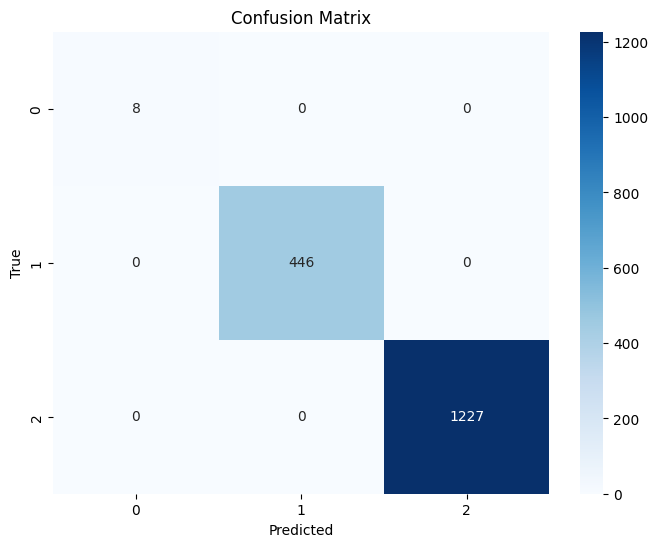

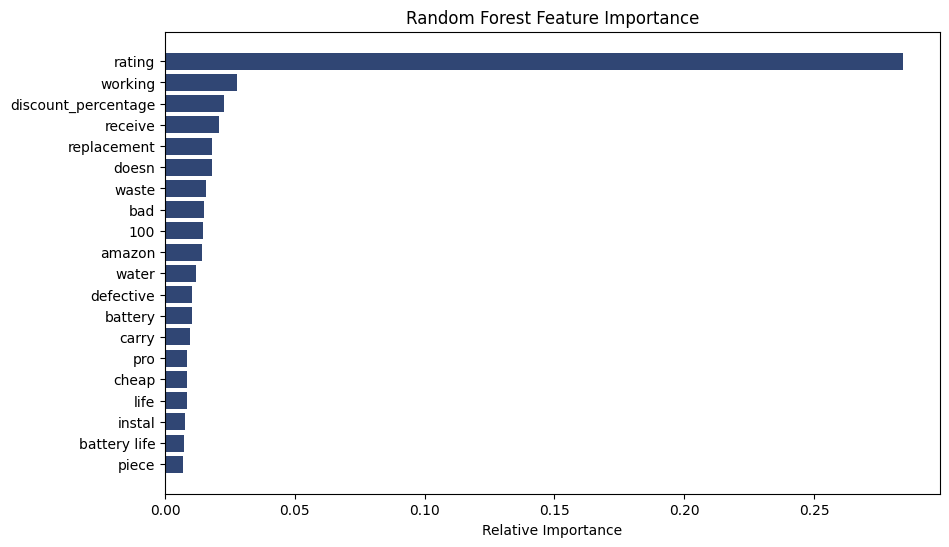

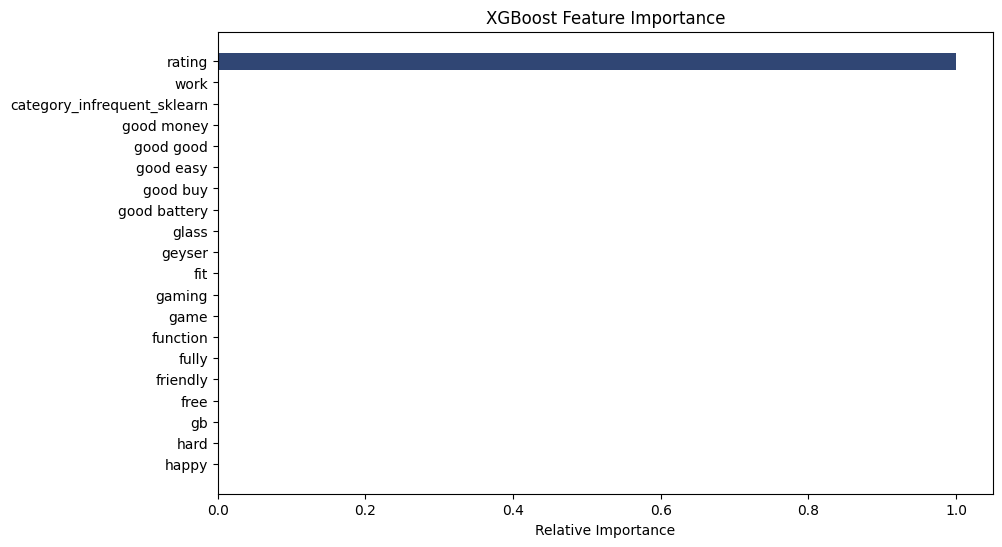


Cross-Validation F1 Scores: [1. 1. 1. 1. 1.]
Mean F1 Score: 1.00 (±0.00)


In [11]:
# Confusion Matrix Plot
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_test, y_pred)

# Feature Importance Plot (for individual models)
def plot_feature_importances(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-20:]
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], color='#304674', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

# Extract feature names
preprocessed_features = pipeline.named_steps['preprocessor'].get_feature_names_out()
feature_names = np.concatenate([
    preprocessor.named_transformers_['text'].get_feature_names_out(),
    ['rating', 'discount_percentage'],
    preprocessor.named_transformers_['cat'].get_feature_names_out(['category'])
])

# Plot individual model importances
rf_trained = pipeline.named_steps['classifier'].estimators_[0]
plot_feature_importances(rf_trained, feature_names, 'Random Forest Feature Importance')

xgb_trained = pipeline.named_steps['classifier'].estimators_[1]
plot_feature_importances(xgb_trained, feature_names, 'XGBoost Feature Importance')

# Cross-validation evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1_weighted')
print(f"\nCross-Validation F1 Scores: {scores}")
print(f"Mean F1 Score: {scores.mean():.2f} (±{scores.std():.2f})")

# Review Sentiment Analysis

<ipython-input-15-778b7bb3f043>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='Set2')


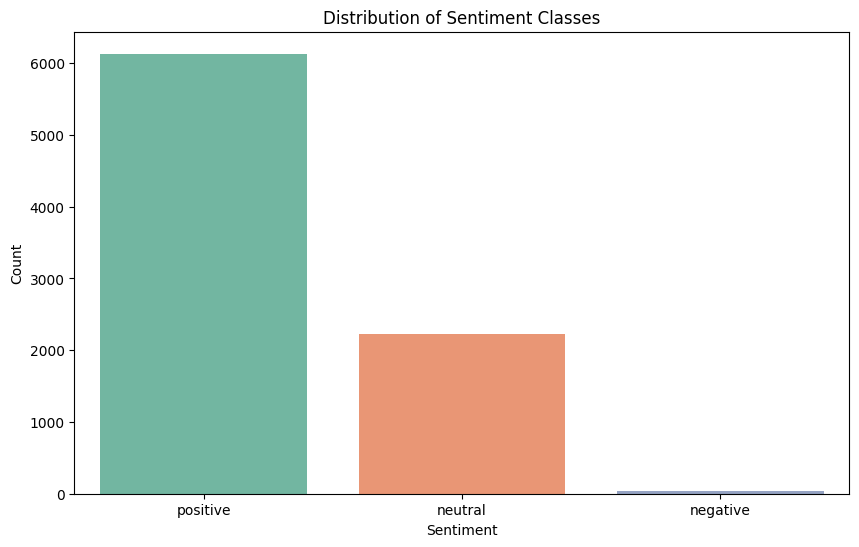

In [ ]:
df['sentiment'] = df['satisfaction'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

# plot value count using seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()



# Apply traditional NLP (TF-IDF + ML classifiers) or Deep Learning models (e.g., BERT, RoBERTa) to classify reviews as Positive, Negative, or Neutral.

# Apply traditional model: Logistic Regression + SVM

In [ ]:
# hadling null values
df['review_content'] = df['review_content'].fillna('')
X = df['review_content']
y = df['sentiment']

# stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Traditional NLP: TF-IDF + ML models
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
lr_pred = lr.predict(X_test_tfidf)

# SVM
svm = SVC()
svm.fit(X_train_tfidf, y_train)
svm_pred = svm.predict(X_test_tfidf)

# Evaluate traditional models
def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1}


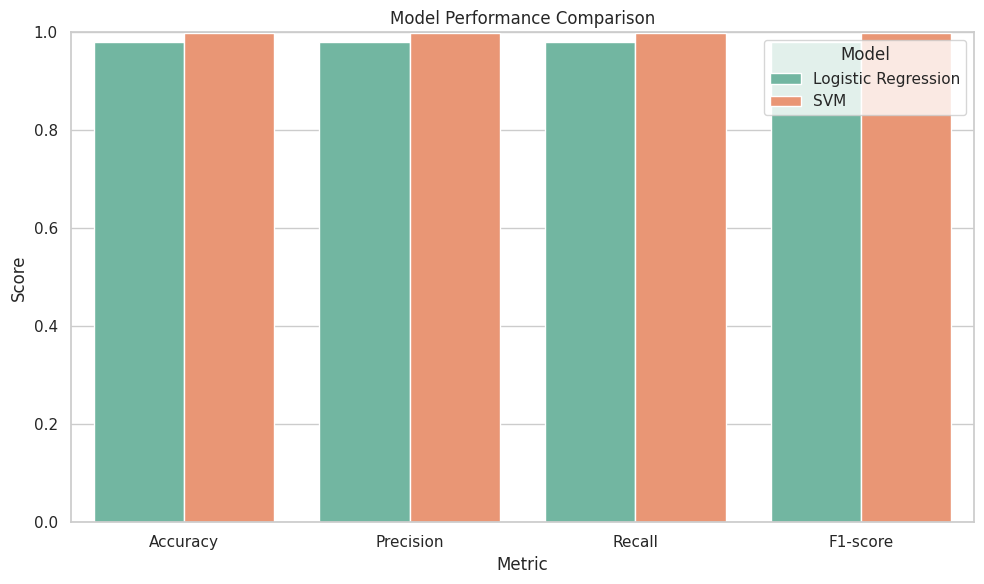

In [ ]:
results = []
results.append(evaluate_model('Logistic Regression', y_test, lr_pred))
results.append(evaluate_model('SVM', y_test, svm_pred))

results_df = pd.DataFrame(results)
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(data=results_melted, x='Metric', y='Score', hue='Model', palette='Set2')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.legend(title='Model')
plt.tight_layout()
plt.show()



<ipython-input-18-0565eae2638d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Logistic Regression', 'SVM'],


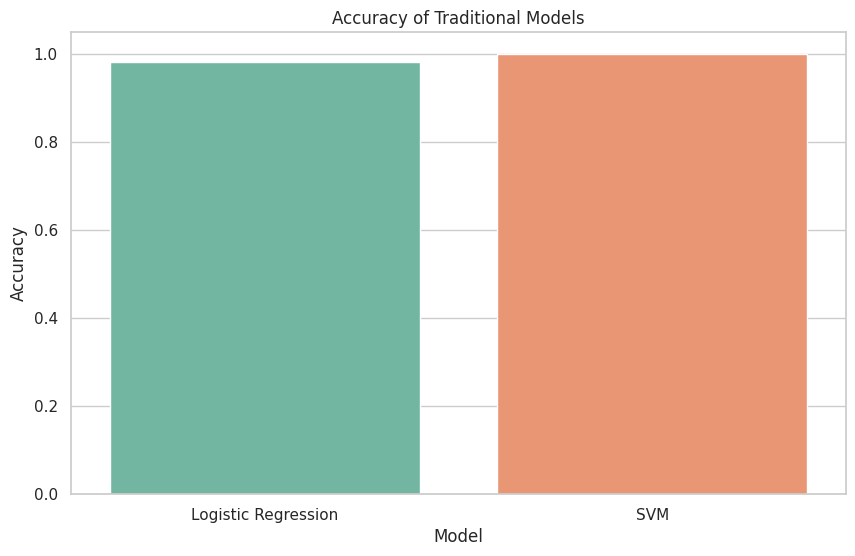

In [ ]:
# plot the results of 2 models using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=['Logistic Regression', 'SVM'],
            y=[accuracy_score(y_test, lr_pred), accuracy_score(y_test, svm_pred)],
            palette='Set2')
plt.title('Accuracy of Traditional Models')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.show()


# Apply Deep Learning Model

# Deep Learning with DistilBERT

In [ ]:

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import numpy as np
import pandas as pd

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Convert string labels to integers
        self.label2id = {label: idx for idx, label in enumerate(sorted(set(labels)))}
        self.labels = [self.label2id[label] for label in labels]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Ensure consistent input format
if isinstance(X_train, pd.Series):
    X_train = X_train.reset_index(drop=True).tolist()
if isinstance(y_train, pd.Series):
    y_train = y_train.reset_index(drop=True).tolist()
if isinstance(X_test, pd.Series):
    X_test = X_test.reset_index(drop=True).tolist()
if isinstance(y_test, pd.Series):
    y_test = y_test.reset_index(drop=True).tolist()

# Initialize DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(set(y_train)))

# Prepare datasets
train_dataset = SentimentDataset(X_train, y_train, tokenizer, max_len=128)
test_dataset = SentimentDataset(X_test, y_test, tokenizer, max_len=128)

# Training arguments
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Colab Notebooks/distilBert_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/Colab Notebooks/distilBert_logs',
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
)

# Trainer init
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.187167
2,0.486700,0.024887
3,0.080100,0.017563


TrainOutput(global_step=1260, training_loss=0.2274136501645285, metrics={'train_runtime': 327.547, 'train_samples_per_second': 61.548, 'train_steps_per_second': 3.847, 'total_flos': 667647595560960.0, 'train_loss': 0.2274136501645285, 'epoch': 3.0})

In [ ]:
# Evaluate DistilBERT
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
preds = np.argmax(logits, axis=1)
true_labels = predictions.label_ids
# Basic scores
print("Accuracy:", accuracy_score(true_labels, preds))
print("\nClassification Report:\n", classification_report(true_labels, preds))
print("\nF1 Score (Macro):", f1_score(true_labels, preds, average='macro'))
print("F1 Score (Micro):", f1_score(true_labels, preds, average='micro'))

Accuracy: 0.9970255800118977

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       1.00      0.99      1.00       446
           2       1.00      1.00      1.00      1227

    accuracy                           1.00      1681
   macro avg       1.00      0.96      0.98      1681
weighted avg       1.00      1.00      1.00      1681


F1 Score (Macro): 0.9755984939799499
F1 Score (Micro): 0.9970255800118977


In [ ]:
import os
import json
# Ensure directory exists
os.makedirs('/content/drive/MyDrive/Colab Notebooks/sentiment_model/distilBERT', exist_ok=True)

model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/sentiment_model/distilBERT')
tokenizer.save_pretrained('/content/drive/MyDrive/Colab Notebooks/sentiment_model/distilBERT')

# Save label2id mapping
label2id_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/sentiment_model/distilBERT', 'label2id.json')
with open(label2id_path, 'w') as f:
    json.dump(train_dataset.label2id, f)

Confusion Matrix:
 [[   7    0    1]
 [   0  442    4]
 [   0    0 1227]]


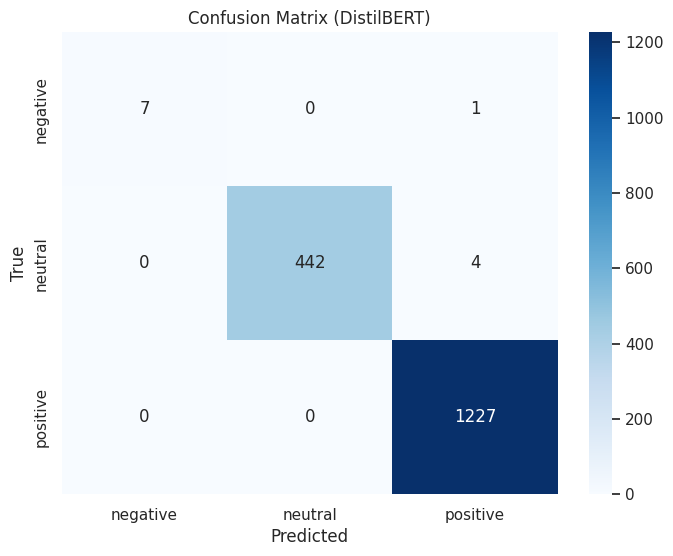

In [ ]:
# Load label2id from training time
with open('/content/drive/MyDrive/Colab Notebooks/sentiment_model/distilBERT/label2id.json') as f:
    label2id = json.load(f)

id2label = {int(v): k for k, v in label2id.items()}  # ensure int keys

string_preds = [id2label[i] for i in preds]
string_true = [id2label[i] for i in true_labels]

cm = confusion_matrix(true_labels, preds)
labels = [id2label[i] for i in sorted(id2label)]

# Text
print("Confusion Matrix:\n", cm)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (DistilBERT)')
plt.show()

In [ ]:
# Binarize labels for ROC-AUC
n_classes = len(set(true_labels))
true_bin = label_binarize(true_labels, classes=range(n_classes))
pred_prob = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()

# ROC-AUC score per class
roc_auc = {}
for i in range(n_classes):
    roc_auc[i] = roc_auc_score(true_bin[:, i], pred_prob[:, i])
    print(f"ROC AUC for class {id2label[i]}: {roc_auc[i]:.4f}")

ROC AUC for class negative: 1.0000
ROC AUC for class neutral: 0.9999
ROC AUC for class positive: 1.0000


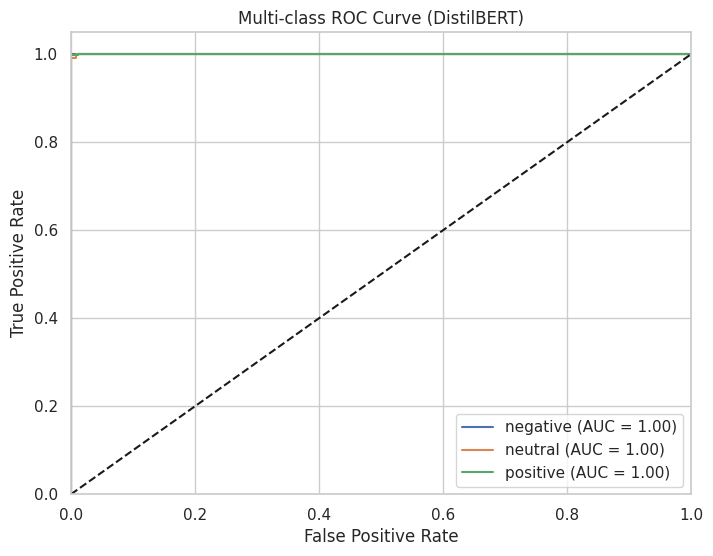

In [ ]:
# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(true_bin[:, i], pred_prob[:, i])
    roc_auc_i = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{id2label[i]} (AUC = {roc_auc_i:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (DistilBERT)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab Notebooks/sentiment_model/distilBERT')
tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/MyDrive/Colab Notebooks/sentiment_model/distilBERT')

# Set model to eval mode
model.eval()

# Load label2id and reverse it to get id2label
with open('/content/drive/MyDrive/Colab Notebooks/sentiment_model/distilBERT/label2id.json', 'r') as f:
    label2id = json.load(f)

# Create id2label, ensuring keys are integers
id2label = {int(v): k for k, v in label2id.items()}

# Inference function
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        predicted_id = torch.argmax(probs, dim=1).item()
        predicted_label = id2label[predicted_id]
    return predicted_label, probs.squeeze().tolist()

text = "This is a good product with many functions."
label, probs = predict_sentiment(text)
print(f"Predicted label: {label}")
print(f"Probabilities: {probs}")

Predicted label: positive
Probabilities: [0.010573343373835087, 0.023851269856095314, 0.9655753970146179]


# Deep Learning with BERT

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y_train)))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y_train)))

train_dataset = SentimentDataset(X_train, y_train, tokenizer, max_len=128)
test_dataset = SentimentDataset(X_test, y_test, tokenizer, max_len=128)

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Colab Notebooks/bert_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/Colab Notebooks/bert_logs',
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.243455
2,0.464300,0.019647
3,0.077900,0.004848


TrainOutput(global_step=1260, training_loss=0.21619132927485873, metrics={'train_runtime': 549.8332, 'train_samples_per_second': 36.666, 'train_steps_per_second': 2.292, 'total_flos': 1326091625349120.0, 'train_loss': 0.21619132927485873, 'epoch': 3.0})

In [ ]:
# Evaluate BERT
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
preds = np.argmax(logits, axis=1)
true_labels = predictions.label_ids
# Basic scores
print("Accuracy:", accuracy_score(true_labels, preds))
print("\nClassification Report:\n", classification_report(true_labels, preds))
print("\nF1 Score (Macro):", f1_score(true_labels, preds, average='macro'))
print("F1 Score (Micro):", f1_score(true_labels, preds, average='micro'))

Accuracy: 0.9994051160023796

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       1.00      1.00      1.00       446
           2       1.00      1.00      1.00      1227

    accuracy                           1.00      1681
   macro avg       1.00      0.96      0.98      1681
weighted avg       1.00      1.00      1.00      1681


F1 Score (Macro): 0.9776420004525911
F1 Score (Micro): 0.9994051160023796


In [ ]:
import os
import json
# Ensure directory exists
os.makedirs('/content/drive/MyDrive/Colab Notebooks/sentiment_model/BERT', exist_ok=True)

model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/sentiment_model/BERT')
tokenizer.save_pretrained('/content/drive/MyDrive/Colab Notebooks/sentiment_model/BERT')

# Save label2id mapping
label2id_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/sentiment_model/BERT', 'label2id.json')
with open(label2id_path, 'w') as f:
    json.dump(train_dataset.label2id, f)

Confusion Matrix:
 [[   7    0    1]
 [   0  446    0]
 [   0    0 1227]]


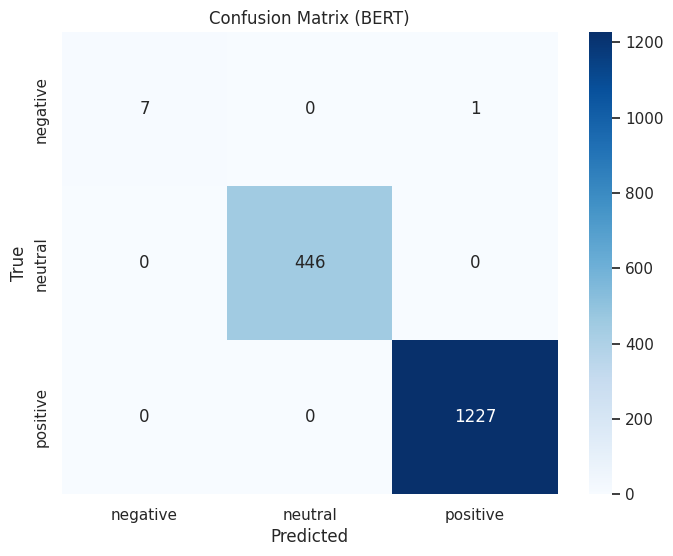

In [ ]:
# Load label2id from training time
with open('/content/drive/MyDrive/Colab Notebooks/sentiment_model/BERT/label2id.json') as f:
    label2id = json.load(f)

id2label = {int(v): k for k, v in label2id.items()}  # ensure int keys

string_preds = [id2label[i] for i in preds]
string_true = [id2label[i] for i in true_labels]

cm = confusion_matrix(true_labels, preds)
labels = [id2label[i] for i in sorted(id2label)]

# Text
print("Confusion Matrix:\n", cm)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (BERT)')
plt.show()

In [ ]:
# Binarize labels for ROC-AUC
n_classes = len(set(true_labels))
true_bin = label_binarize(true_labels, classes=range(n_classes))
pred_prob = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()

# ROC-AUC score per class
roc_auc = {}
for i in range(n_classes):
    roc_auc[i] = roc_auc_score(true_bin[:, i], pred_prob[:, i])
    print(f"ROC AUC for class {id2label[i]}: {roc_auc[i]:.4f}")

ROC AUC for class negative: 1.0000
ROC AUC for class neutral: 1.0000
ROC AUC for class positive: 1.0000


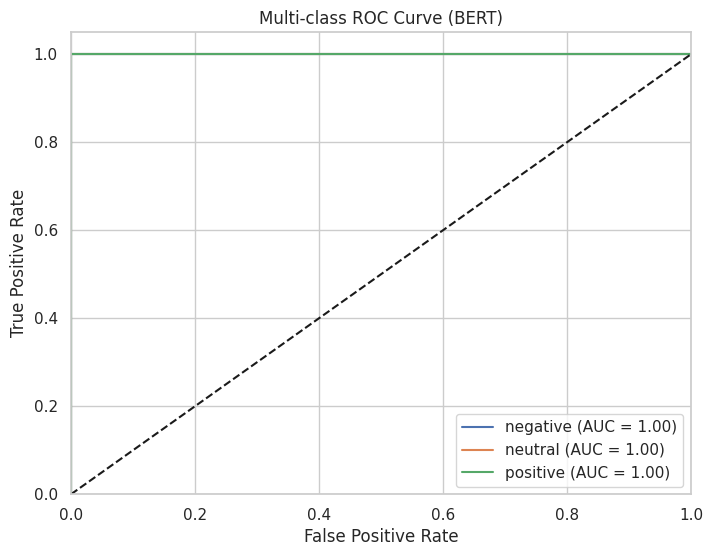

In [ ]:
# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(true_bin[:, i], pred_prob[:, i])
    roc_auc_i = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{id2label[i]} (AUC = {roc_auc_i:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (BERT)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab Notebooks/sentiment_model/BERT')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/Colab Notebooks/sentiment_model/BERT')

# Set model to eval mode
model.eval()

# Load label2id and reverse it to get id2label
with open('/content/drive/MyDrive/Colab Notebooks/sentiment_model/BERT/label2id.json', 'r') as f:
    label2id = json.load(f)

# Create id2label, ensuring keys are integers
id2label = {int(v): k for k, v in label2id.items()}

# Inference function
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        predicted_id = torch.argmax(probs, dim=1).item()
        predicted_label = id2label[predicted_id]
    return predicted_label, probs.squeeze().tolist()

text = "This is a good product with many functions."
label, probs = predict_sentiment(text)
print(f"Predicted label: {label}")
print(f"Probabilities: {probs}")

Predicted label: positive
Probabilities: [0.00047613208880648017, 0.0010968383867293596, 0.9984270334243774]


# Summarize the customer review

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration

tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

review_text = "I recently purchased this wireless Bluetooth speaker and overall, I’m pretty happy with it. The sound quality is excellent—clear highs and decent bass for the size. It’s compact and easy to carry around, which is perfect for my outdoor trips. The battery life lasts about 8 hours on a full charge, which meets my expectations.However, the delivery took longer than promised, arriving almost a week late. The packaging was a bit damaged, but thankfully the product inside was unharmed. Also, I had some trouble connecting it to my phone at first, but after restarting both devices it worked fine.For the price, I think it offers good value. I would recommend it to anyone looking for a portable speaker but be prepared for possible delivery delays."

summary = summarizer(review_text, max_length=100, min_length=30, do_sample=False)
print(summary[0]['summary_text'])

Device set to use cuda:0


The sound quality is excellent and the battery life lasts about 8 hours on a full charge. The delivery took longer than promised, arriving almost a week late. I would recommend it to anyone looking for a portable speaker.
